## 이상치 제거

![](https://velog.velcdn.com/images/newnew_daddy/post/6a1e20c2-da20-4dcd-89be-6db0a794840e/image.png)

- 이상치란 관측된 데이터의 범위에서 많이 벗어난 값들을 의미한다.
- 상관 관계를 파악할 때, 이러한 소수의 이상치가 큰 영향을 미칠 수 있기 때문에 전처리 과정에서 이상치 처리는 필수적이다.
- "데이터의 범위에서 많이 벗어난"의 기준이 주관적일 수 있기 때문에 이상치를 탐지하는 몇 가지 방법론들을 활용하여 이상치를 효율적이고 일관적인 기준으로 제거한다.

#### 1. IQR(Inter Quantile Range) - 사분위수 기반
<img src="https://velog.velcdn.com/images/newnew_daddy/post/496a9887-06c8-4afc-8fef-8f4de7913875/image.png" width="60%">

[출처 : wikipedia]

- IQR 방법은 데이터의 중앙값과 사분위수를 기반으로 이상치를 검출합니다. 주로 비정규 분포 데이터에 유용합니다.
- 사분위 : 데이터를 4등분 했을 때의 범위
  - Q1 : 데이터의 하위 25%에 해당하는 값
  - Q2 : 데이터의 절반. 즉, 중앙값
  - Q3 : 데이터의 상위 25%에 해당하는 값
  - IQR : Q3 - Q1
  - IQR의 1.5배를 Q1에서 빼고, Q3에 더했을 때, 그 범위 밖에 있는 값들을 이상치로 간주.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# 이상치가 포함된 샘플 데이터 생성 (정수형)
np.random.seed(42)
data = np.random.normal(loc=50, scale=5, size=45).astype(int)  # 정상 데이터
low_out = np.random.uniform(low=5, high=20, size=5).astype(int)  # 이상치 데이터
high_out = np.random.uniform(low=80, high=95, size=5).astype(int)  # 이상치 데이터

# 정상 데이터와 이상치 데이터를 합침
data_with_outliers = np.concatenate([data, low_out, high_out])
df = pd.DataFrame(data_with_outliers, columns=['value'])

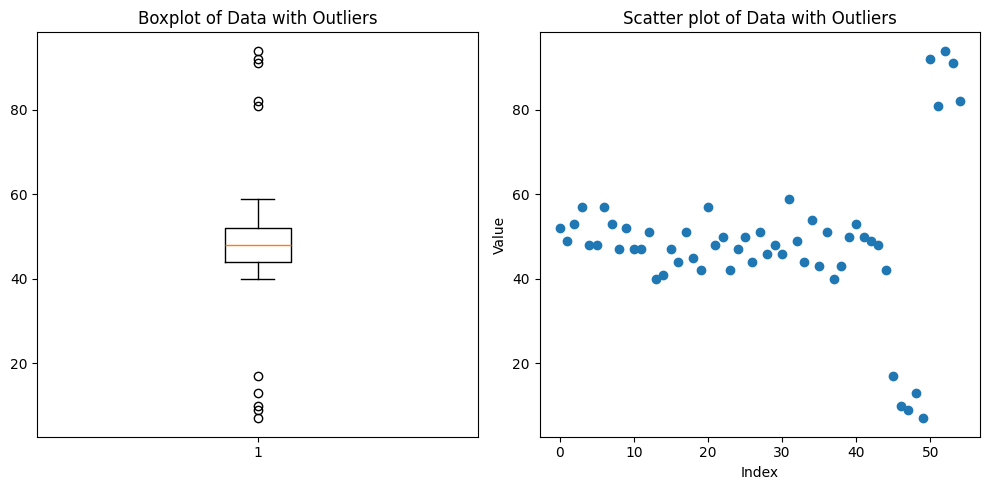

In [23]:
# Boxplot을 통해 이상치 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(df['value'])
plt.title('Boxplot of Data with Outliers')

# Scatter plot을 통해 이상치 시각화
plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['value'])
plt.title('Scatter plot of Data with Outliers')
plt.xlabel('Index')
plt.ylabel('Value')

plt.tight_layout()
plt.show()


In [24]:
# IQR 방법
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
iqr_filtered_df = df[(df['value'] >= (Q1 - 1.5 * IQR)) & (df['value'] <= (Q3 + 1.5 * IQR))]

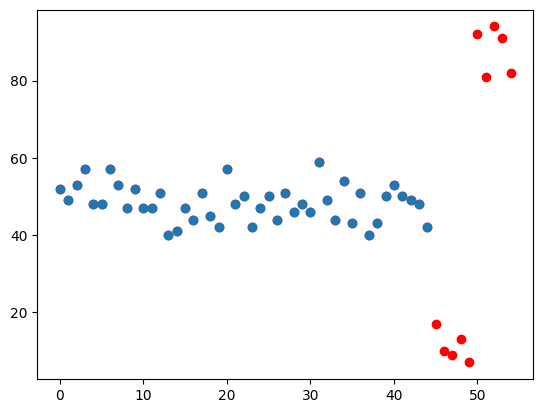

In [25]:
plt.scatter(range(len(df)), df['value'], c='red')
plt.scatter(range(len(iqr_filtered_df)), iqr_filtered_df['value'])

#### 2. Z-Score (표준편차 기반 이상치 제거)

![](https://velog.velcdn.com/images/newnew_daddy/post/aece5c38-10ec-41ca-b70c-eae45b875623/image.png)


- 데이터의 평균과 표준편차를 계산하여, 일반적인 범위를 벗어난 데이터를 이상치로 간주
- 일반적으로 평균에서 ±3개의 표준편차 이상으로 떨어진 데이터를 이상치로 판단.

![](https://velog.velcdn.com/images/newnew_daddy/post/57bceac8-0278-4c46-88c0-4861ef80dfa3/image.png)

- **예시**
  - 주어진 데이터 집합의 평균이 100, 표준편차가 10 일 때,
  - 이상치 기준
    - μ−3σ=50−3⋅10=20 이하  or  μ+3σ=50+3⋅10=80 이상
  - 88인 지점의 Z-Score
    - (X-평균) / 표준편차  =  (88-100) / 10  =  -1.2



In [29]:
mean = np.mean(df['value'])
std = np.std(df['value'])
z_filtered_df = df[(df['value'] >= mean - 2 * std) & (df['value'] <= mean + 2 * std)]

In [30]:
mean, std, np.var(df['value'])

(48.56363636363636, 17.017385373748745, 289.5914049586777)

In [33]:
def zscore_filter(df, zscore):
    
    mean = np.mean(df['value'])
    std = np.std(df['value'])
    z_filtered_df = df[(df['value'] >= mean - zscore * std) & (df['value'] <= mean + zscore * std)]
    
    return z_filtered_df

In [44]:
filtered_df = zscore_filter(df, 2)

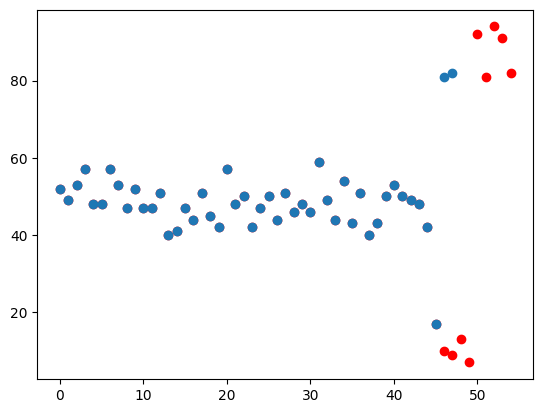

In [45]:
plt.scatter(range(len(df)), df['value'], c='red')
plt.scatter(range(len(filtered_df)), filtered_df['value'])

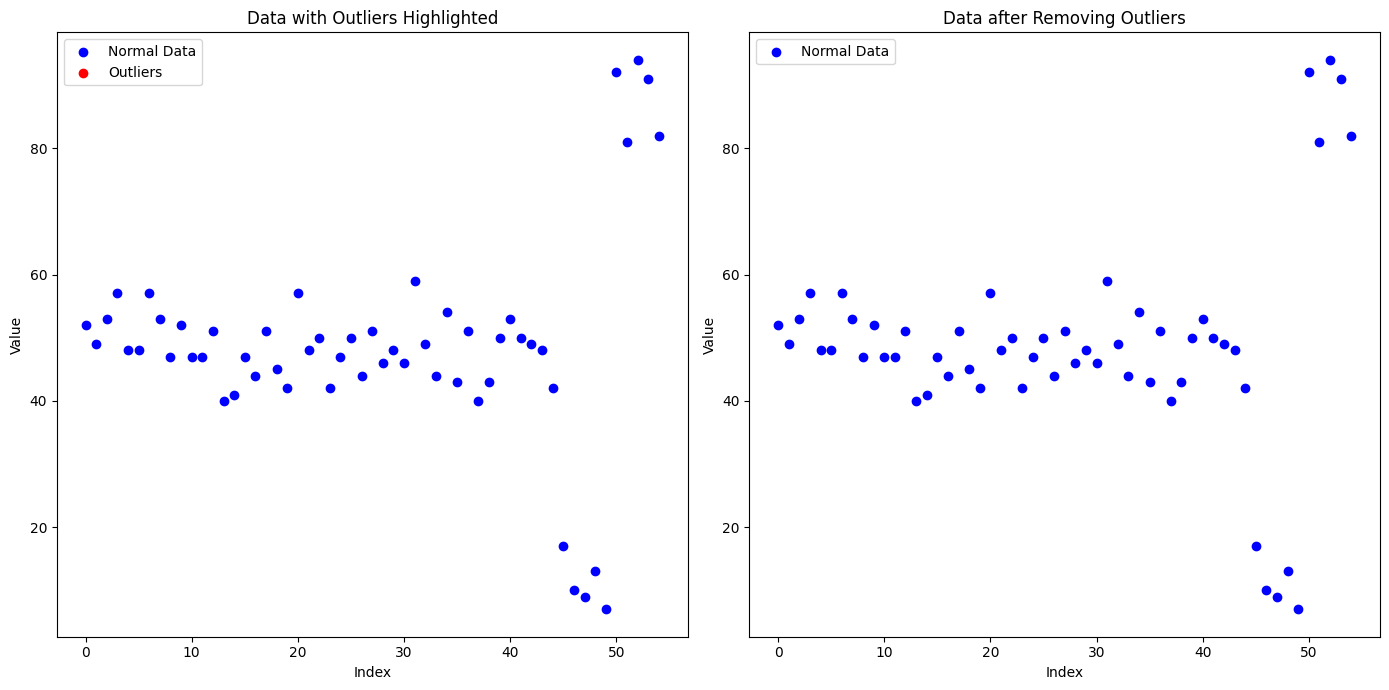

In [32]:
# Z-score 계산
df['zscore'] = zscore(df['value'])

# Z-score가 3보다 큰 경우를 이상치로 간주
df['outlier'] = df['zscore'].abs() > 3

# 이상치와 정상 데이터를 구분하여 시각화
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(range(len(df)), df['value'], c='blue', label='Normal Data')
plt.scatter(df[df['outlier']].index, df[df['outlier']]['value'], c='red', label='Outliers')
plt.title('Data with Outliers Highlighted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# 이상치 제거 후 데이터 시각화
cleaned_df = df[~df['outlier']]

plt.subplot(1, 2, 2)
plt.scatter(range(len(cleaned_df)), cleaned_df['value'], c='blue', label='Normal Data')
plt.title('Data after Removing Outliers')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()
